In [2]:
import pandas as pd
import numpy as np

# Finding optimal execution strategy over a fixed period of times for a target order via the Dynamic programming approach.

$m_t=m_{t-1}+\mu+\lambda s_t+e_t$

$p_t=m_t+\gamma s_t$

If $\mu=0$, $s^\star_t=S/T$

Else, $s^\star_t=S(\frac{1}{T}+\frac{T+1-2t}{4\gamma +2\lambda} \mu)$

In [90]:
def size_optimal(T,S,mu,gamma,lbd):
    if mu==0:
        return np.ones(T)*S/float(T)
    else:
        return S*(1.0/float(T)+(T+1.)*mu/float(4*gamma+2*lbd))-np.arange(1,T+1)*S*mu/float(2*gamma+lbd)

In [6]:
#Ex
size_optimal(10,10000,0.01,0.2,0.5)

array([1500.        , 1388.88888889, 1277.77777778, 1166.66666667,
       1055.55555556,  944.44444444,  833.33333333,  722.22222222,
        611.11111111,  500.        ])

We need good estimates of the hidden parameters which we will fit using the market quote and price data.

In [189]:
df=pd.read_csv('A_test_quote.csv',header=0)

In [190]:
df.head(5)

,DATE,TIME_M,EX,BID,BIDSIZ,ASK,ASKSIZ,QU_COND,QU_SEQNUM,NATBBO_IND,QU_CANCEL,QU_SOURCE,SYM_ROOT,SYM_SUFFIX
0,20181217,9:30:00.318357475,Y,66.29,1,71.76,1,R,15918201,A,NaN,C,A,NaN
1,20181217,9:30:00.760058312,X,68.61,1,69.51,3,R,15999901,A,NaN,C,A,NaN
2,20181217,9:30:01.005804310,N,69.05,3,69.11,1,O,16045207,G,NaN,C,A,NaN
3,20181217,9:30:01.006097451,P,68.62,1,69.23,1,R,16046601,A,NaN,C,A,NaN
4,20181217,9:30:01.006124860,P,68.62,1,70.41,1,R,16046802,A,NaN,C,A,NaN


In [195]:
Mt=[]
T=[]
for j in range(len(df['TIME_M'])):
    
    if np.array(df['TIME_M'])[j][:6]+'0' not in T and np.array(df['BID'])[j]>0 and np.array(df['ASK'])[j]<199999.99:       
        T.append(np.array(df['TIME_M'])[j][:6]+'0')  
        Mt.append(0.5*(np.array(df['BID'])[j]+np.array(df['ASK'])[j]))
    else:
        pass

In [197]:
import time
import datetime
mt=[]
tt=[]
start=datetime.datetime.strptime("09:30:00", "%H:%M:%S")
j=0
for i in range(180):
    tt.append(start)
    if start==datetime.datetime.strptime(T[j],'%H:%M:%S'):
        mt.append(Mt[j])
        j+=1
    else:
        mt.append(Mt[j])
    start+=datetime.timedelta(0,10)

In [200]:
mt=np.array(mt)
len(mt),len(tt)

(180, 180)

In [201]:
df_t=pd.read_csv('A_test_trade.csv',header=0)


In [202]:
df_t.head(5)

,DATE,TIME_M,EX,SYM_ROOT,SYM_SUFFIX,TR_SCOND,SIZE,PRICE,TR_CORR,TR_SEQNUM,TR_SOURCE,TR_RF
0,20181217,9:30:01.005852000,N,A,NaN,O,19875,69.11,0,279001,C,NaN
1,20181217,9:30:01.011290000,N,A,NaN,NaN,100,69.11,0,283401,C,NaN
2,20181217,9:30:01.019645000,D,A,NaN,NaN,100,69.06,0,284301,C,T
3,20181217,9:30:03.195176000,P,A,NaN,NaN,100,69.05,0,311701,C,NaN
4,20181217,9:30:03.195210000,P,A,NaN,Q,100,69.05,0,311801,C,NaN


In [203]:
Pt=[]
St=[]
T2=[]
i=-1
for j in range(len(df_t['TIME_M'])):
    if np.array(df_t['TIME_M'])[j][:6]+'0' not in T2:
        i+=1
        T2.append(np.array(df_t['TIME_M'])[j][:6]+'0')
        Pt.append(np.array(df_t['PRICE'])[j])
        St.append(np.array(df_t['SIZE'])[j])
    else:
        St[i]+=np.array(df_t['SIZE'])[j]

In [204]:
len(T2),len(Pt)

(136, 136)

In [205]:
pt=[]
st=[]
ttt=[]
start=datetime.datetime.strptime("09:30:00", "%H:%M:%S")
j=0
for i in range(180):
    ttt.append(start)
    if j<len(T2):
        if start==datetime.datetime.strptime(T2[j],'%H:%M:%S'):
        
            pt.append(Pt[j])
            st.append(St[j])
            j+=1
        else:
            pt.append(pt[-1])
            st.append(0)
    else:
        pt.append(pt[-1])
        st.append(0)
    start+=datetime.timedelta(0,10)

In [206]:
pt=np.array(pt)
st=np.array(st)

In [207]:
common=sorted(set(tt).intersection(set(ttt)))
len(common)

180

In [214]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
regr = linear_model.LinearRegression()
regr.fit(st[1:].reshape(-1,1),np.diff(mt))
mu=regr.intercept_
lbd=regr.coef_[0]
mu,lbd

(0.1339814147297396, -0.0002747781251320721)

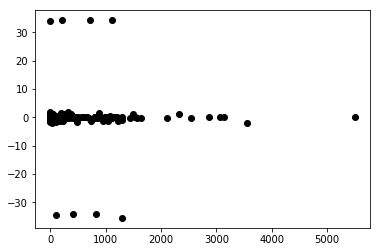

In [215]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.plot(st[1:].reshape(-1,1),np.diff(mt),'ko')

In [216]:
regr2 = linear_model.LinearRegression()
regr2.fit(st.reshape(-1,1),pt-mt)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [217]:
gamma=regr2.coef_[0]
gamma

1.54804877096709e-05

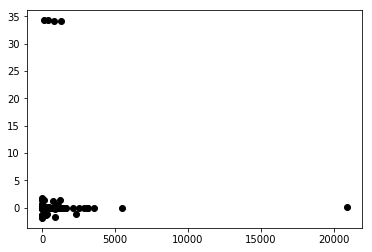

In [219]:
plt.plot(st.reshape(-1,1),pt-mt,'ko')

In [220]:
size_optimal(10,10000,mu,gamma,lbd)

array([-24727218.13372009, -19232058.54844895, -13736898.96317782,
        -8241739.3779067 ,  -2746579.79263557,   2748579.79263556,
         8243739.37790669,  13738898.96317782,  19234058.54844895,
        24729218.13372008])